In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm

%matplotlib inline

In [2]:
import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Concatenate, Input, concatenate
from keras.layers import Conv2D, AveragePooling2D
from keras import backend as K

from sklearn.model_selection import train_test_split

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

Using TensorFlow backend.


In [3]:
# load the files
houselist = glob.glob('HousesDataset/*.jpg')

image_data = []
for fname in houselist:
    image_name = fname.split('\\')[1].split('.')[0]
    image_data.append((image_name, Image.open(fname)))
    pass

text_data = pd.read_csv('HousesDataset/HousesInfo.txt', sep=' ',
                        names=["nBeds", "nbaths", "area", "zipcode", "price"])

In [4]:
image_same_size = []
for name, image in tqdm(image_data):
    image_same_size.append((name, image.resize((300, 300))))

100%|█████████████████████████████████████████████████████████████████████████████| 2140/2140 [00:20<00:00, 106.12it/s]


In [5]:
row, col = 100, 100
X11 = np.zeros((535, row, col, 3)).astype(int)
X12 = np.zeros((535, row, col, 3)).astype(int)
X13 = np.zeros((535, row, col, 3)).astype(int)
X14 = np.zeros((535, row, col, 3)).astype(int)
for name, image in tqdm(image_data):
    index, room = name.split('_')
    if room == "bathroom":
        X11[int(index) - 1, :, :] = np.array(image.resize((row, col)))
    elif room == "bedroom":
        X12[int(index) - 1, :, :] = np.array(image.resize((row, col)))
    elif room == "frontal":
        X13[int(index) - 1, :, :] = np.array(image.resize((row, col)))
    else:
        X14[int(index) - 1, :, :] = np.array(image.resize((row, col)))

100%|████████████████████████████████████████████████████████████████████████████| 2140/2140 [00:00<00:00, 7307.80it/s]


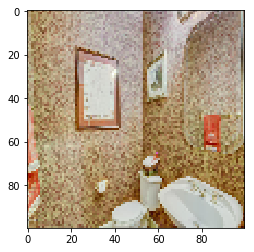

In [8]:
plt.imshow(X11[0])

In [9]:
text_array = np.zeros((535, 5))
for i, text in text_data.iterrows():
    text_array[i] = text.values

In [10]:
X2 = text_array[:, :4]
y = text_array[:, -1]

In [11]:
shuffle = np.arange(len(y))
np.random.shuffle(shuffle)

X11 = X11[shuffle]
X12 = X12[shuffle]
X13 = X13[shuffle]
X14 = X14[shuffle]
X2 = X2[shuffle]
y = y[shuffle]

x11_train = X11[:400]
x12_train = X12[:400]
x13_train = X13[:400]
x14_train = X14[:400]
x2_train = X2[:400]
y_train = y[:400]

x11_test = X11[400:]
x12_test = X12[400:]
x13_test = X13[400:]
x14_test = X14[400:]
x2_test = X2[400:]
y_test = y[400:]

In [12]:
# cnn model
def visual_model(input_layer):
    conv1 = Conv2D(32, kernel_size=(5, 5), activation='relu')(input_layer)
    bat1 = BatchNormalization()(conv1)
    pool1 = AveragePooling2D(pool_size=(2, 2))(bat1)
    conv2 = Conv2D(64, kernel_size=(5, 5), activation='relu')(pool1)
    bat2 = BatchNormalization()(conv2)
    pool2 = AveragePooling2D(pool_size=(2, 2))(bat2)
    conv3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(pool2)
    bat3 = BatchNormalization()(conv3)
    pool3 = AveragePooling2D(pool_size=(2, 2))(bat3)
    return Flatten()(pool3)

In [13]:
# visual features
visual_input1 = Input(shape=(row, col, 3), name='visual_input1')
visual1 = visual_model(visual_input1)

visual_input2 = Input(shape=(row, col, 3), name='visual_input2')
visual2 = visual_model(visual_input2)

visual_input3 = Input(shape=(row, col, 3), name='visual_input3')
visual3 = visual_model(visual_input3)

visual_input4 = Input(shape=(row, col, 3), name='visual_input4')
visual4 = visual_model(visual_input4)

Instructions for updating:
Colocations handled automatically by placer.


In [14]:
# textual features
textual_input = Input(shape=(3,), name='textual_input')

In [15]:
x = keras.layers.concatenate([visual1, visual2, visual3, visual4, textual_input])

# We stack a deep densely-connected network on top
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)

# And finally we add the main regression layer
main_output = Dense(1, activation='linear', name='main_output')(x)

In [16]:
model = Model(inputs=[visual_input1, visual_input2, visual_input3, visual_input4, textual_input], outputs=main_output)

In [18]:
model.compile(optimizer='adadelta',
              loss={'main_output': 'mean_absolute_error'}, metrics={'main_output': [coeff_determination]})

# And trained it via:
model.fit({'visual_input1': X11, 'visual_input2': X12, 'visual_input3': X13, 'visual_input4': X14,
           'textual_input': X2[:, :3]},
          {'main_output': y},
          validation_split=0.3,
          epochs=300, batch_size=128)

Train on 374 samples, validate on 161 samples
Epoch 1/300
374/374 [==============================] - 5s 13ms/step - loss: 38050.4522 - coeff_determination: 0.9860 - val_loss: 338555.2465 - val_coeff_determination: 0.1411
Epoch 2/300
374/374 [==============================] - 1s 3ms/step - loss: 35732.0629 - coeff_determination: 0.9861 - val_loss: 346647.0499 - val_coeff_determination: 0.1610
Epoch 3/300
374/374 [==============================] - 1s 3ms/step - loss: 29532.8366 - coeff_determination: 0.9917 - val_loss: 346339.5982 - val_coeff_determination: 0.1516
Epoch 4/300
374/374 [==============================] - 1s 3ms/step - loss: 24594.3854 - coeff_determination: 0.9939 - val_loss: 330236.9647 - val_coeff_determination: 0.1782
Epoch 5/300
374/374 [==============================] - 1s 3ms/step - loss: 36188.5292 - coeff_determination: 0.9890 - val_loss: 336421.3282 - val_coeff_determination: 0.1506
Epoch 6/300
374/374 [==============================] - 1s 3ms/step - loss: 29073.71

In [191]:
6.1426 * y.std() + y.mean()

3713182.7773603927